# 06 – Transfer Learning with YAMNet Embeddings (Full Sequence)

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Transfer Learning with YAMNet Embeddings (Preserving Temporal Information)

---

## Overview

In this notebook, we explore an alternative approach to transfer learning with YAMNet.
Unlike `05_transfer_learning.ipynb` which averages embeddings over time, here we:

1. Extract **full sequence of embeddings** from YAMNet (preserving temporal information)
2. Pad or truncate embeddings to a fixed length (100 frames × 1024 dimensions)
3. Train a Dense neural network on the flattened embedding sequences
4. Compare this approach to our previous models

**Key Difference:**

- **Notebook 05**: Averages embeddings → single 1024-D vector per clip
- **This notebook**: Uses full sequence → (100, 1024) per clip → flattened to (100×1024,)

**Goals:**

- Preserve temporal information in YAMNet embeddings
- Train a classifier on full embedding sequences
- Evaluate and compare with previous approaches


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

import soundfile as sf
import scipy.signal
import librosa
import librosa.display

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and constants
DATA_DIR = Path("../data").resolve()
SAMPLE_RATE = 16000  # YAMNet expects 16 kHz audio
MAX_FRAMES = 100  # Fixed number of embedding frames per clip

CLASS_NAMES = ["dog", "cat", "bird"]
print(f"Data directory: {DATA_DIR}")
print(f"Sample rate: {SAMPLE_RATE} Hz")
print(f"Max embedding frames: {MAX_FRAMES}")


Data directory: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/data
Sample rate: 16000 Hz
Max embedding frames: 100


## 2. Helper Functions: Audio Loading

We define a function to load audio files using librosa, which ensures proper float32 format compatible with both visualization and YAMNet.


In [7]:
def read_audio(filename):
    """
    Read audio file using librosa (ensures float32 format).
    This is compatible with both librosa visualization and YAMNet.
    
    Args:
        filename: Path to audio file
    
    Returns:
        sample_rate, waveform (as numpy array, float32, normalized to [-1, 1])
    """
    # Use librosa.load which automatically:
    # - Converts to float32
    # - Normalizes to [-1, 1] range
    # - Converts to mono if stereo
    # - Resamples to desired sample rate
    wav_data, sample_rate = librosa.load(filename, sr=SAMPLE_RATE, mono=True, dtype=np.float32)
    
    return sample_rate, wav_data

# Test the function
test_file = list((DATA_DIR / "dog").glob("*.wav"))[0] if (DATA_DIR / "dog").exists() else None
if test_file:
    sr, wav = read_audio(str(test_file))
    print(f"✓ Test file loaded: {test_file.name}")
    print(f"  Sample rate: {sr} Hz")
    print(f"  Duration: {len(wav)/sr:.2f} seconds")
    print(f"  Shape: {wav.shape}")
    print(f"  Dtype: {wav.dtype}")


✓ Test file loaded: 62581901_nohash_0.wav
  Sample rate: 16000 Hz
  Duration: 1.00 seconds
  Shape: (16000,)
  Dtype: float32


✓ Test file loaded: 62581901_nohash_0.wav
  Sample rate: 16000 Hz
  Duration: 1.00 seconds
  Shape: (16000,)


## 3. Load Dataset and Create DataFrame

We iterate through the data directory and collect audio data with their class labels.


In [8]:
# Gather audio data and labels
audio_data_list = []  # List of audio waveforms
labels_list = []  # List of class labels

print("Loading audio files...")
for class_name in CLASS_NAMES:
    class_dir = DATA_DIR / class_name
    if not class_dir.exists():
        print(f"⚠️  Warning: {class_dir} does not exist, skipping...")
        continue
    
    wav_files = list(class_dir.glob("*.wav"))
    print(f"Processing {len(wav_files)} files from '{class_name}'...")
    
    for wav_file in wav_files:
        try:
            sample_rate, wav_data = read_audio(str(wav_file))
            audio_data_list.append(wav_data)
            labels_list.append(class_name)
        except Exception as e:
            print(f"  ⚠️  Error loading {wav_file.name}: {e}")
            continue

print(f"\n✓ Dataset loaded: {len(audio_data_list)} samples")
print(f"\nClass distribution:")
label_counts = Counter(labels_list)
for class_name in CLASS_NAMES:
    count = label_counts.get(class_name, 0)
    print(f"  {class_name}: {count} samples")


Loading audio files...
Processing 210 files from 'dog'...
Processing 207 files from 'cat'...
Processing 193 files from 'bird'...

✓ Dataset loaded: 610 samples

Class distribution:
  dog: 210 samples
  cat: 207 samples
  bird: 193 samples


## 4. Visualize Sample Audio Files

Let's visualize waveforms from each class to understand the data.


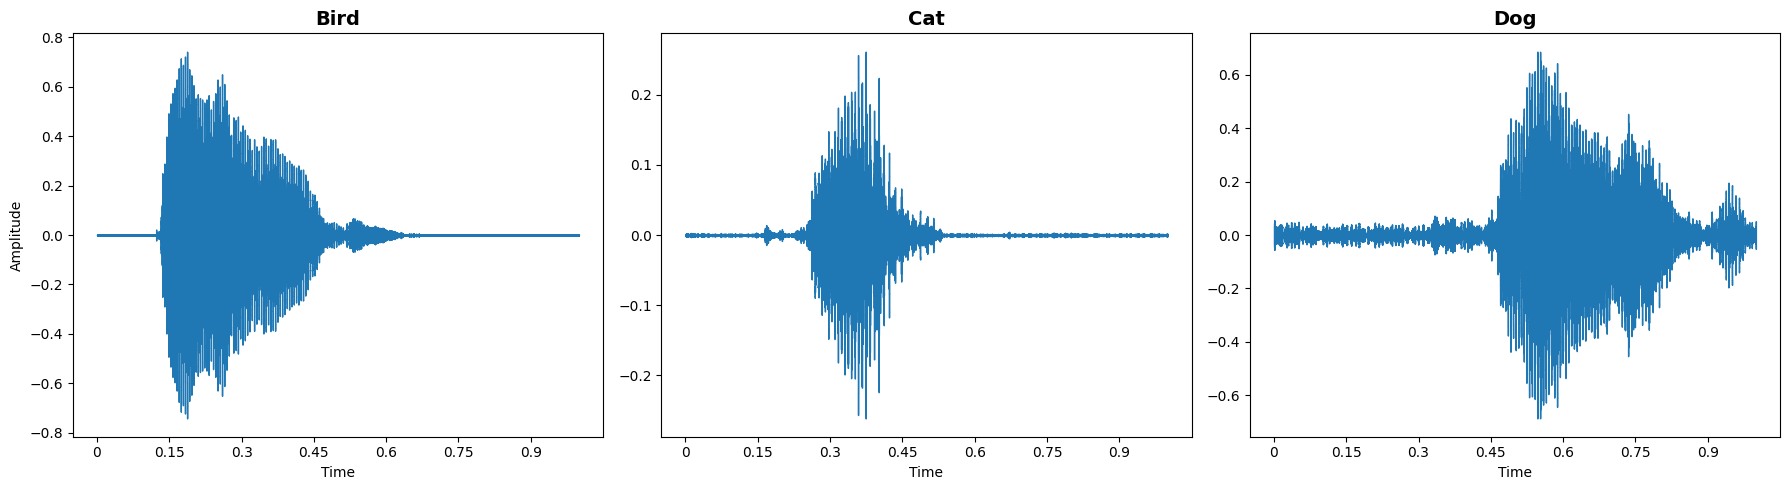

In [10]:
# Get one sample from each class
bird_idx = labels_list.index("bird") if "bird" in labels_list else None
cat_idx = labels_list.index("cat") if "cat" in labels_list else None
dog_idx = labels_list.index("dog") if "dog" in labels_list else None

# Visualize waveforms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

if bird_idx is not None:
    librosa.display.waveshow(audio_data_list[bird_idx], sr=SAMPLE_RATE, ax=ax1)
    ax1.set_title("Bird", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Amplitude")

if cat_idx is not None:
    librosa.display.waveshow(audio_data_list[cat_idx], sr=SAMPLE_RATE, ax=ax2)
    ax2.set_title("Cat", fontsize=14, fontweight='bold')

if dog_idx is not None:
    librosa.display.waveshow(audio_data_list[dog_idx], sr=SAMPLE_RATE, ax=ax3)
    ax3.set_title("Dog", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Load YAMNet Model

We load the pre-trained YAMNet model. YAMNet returns:
- **Class scores**: Probability of audio belonging to each of 521 trained classes
- **Embeddings**: Dense continuous representation (1024-D per frame) - we use this
- **Log mel Spectrograms**: Internal representation

**Note**: We use the local path to avoid SSL certificate issues (same as notebook 05).


In [11]:
# Load YAMNet from local path (downloaded SavedModel)
# This avoids SSL certificate issues and makes the project reproducible
YAMNET_HANDLE = Path("../models/yamnet").resolve().as_posix()

if not Path(YAMNET_HANDLE).exists():
    print("⚠️  Local YAMNet not found, trying TensorFlow Hub...")
    YAMNET_HANDLE = 'https://tfhub.dev/google/yamnet/1'

print(f"Loading YAMNet from: {YAMNET_HANDLE}")
yamnet_model = hub.load(YAMNET_HANDLE)
print("✓ YAMNet loaded successfully.")

Loading YAMNet from: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/models/yamnet
✓ YAMNet loaded successfully.


## 6. Extract YAMNet Embeddings (Full Sequence)

Unlike notebook 05 where we averaged embeddings, here we preserve the full sequence of embeddings.
Each audio clip produces a sequence of embeddings (one per time frame), which we pad/truncate to a fixed length.

**Important**: Before feeding data to YAMNet, we normalize waveforms to the range [-1, 1] (YAMNet expects float32 in this range).

In [13]:
# Extract YAMNet embeddings directly from the list
# Note: We iterate over the list directly since audio files have different lengths
# and cannot be converted to a homogeneous numpy array

print(f"Total audio files: {len(audio_data_list)}")
print(f"Extracting YAMNet embeddings (preserving full sequence)...")

audio_embeddings = []

for i, waveform in enumerate(audio_data_list):
    # Normalize waveform to [-1, 1] range (YAMNet expects float32 in this range)
    # librosa.load already normalizes, but ensure it's in the right range
    waveform_normalized = waveform.astype(np.float32)
    
    # Convert to Tensor (YAMNet expects shape (num_samples,))
    waveform_tf = tf.convert_to_tensor(waveform_normalized, dtype=tf.float32)
    
    # Run YAMNet
    # Returns: scores (class predictions), embeddings (1024-D per frame), spectrogram
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # Store the full sequence of embeddings (shape: (num_frames, 1024))
    audio_embeddings.append(embeddings)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_data_list)} files")

print(f"\n✓ Embeddings extracted for {len(audio_embeddings)} files")
print(f"  Example embedding shape: {audio_embeddings[0].shape}")

Total audio files: 610
Extracting YAMNet embeddings (preserving full sequence)...
  Processed 50/610 files
  Processed 100/610 files
  Processed 150/610 files
  Processed 200/610 files
  Processed 250/610 files
  Processed 300/610 files
  Processed 350/610 files
  Processed 400/610 files
  Processed 450/610 files
  Processed 500/610 files
  Processed 550/610 files
  Processed 600/610 files

✓ Embeddings extracted for 610 files
  Example embedding shape: (2, 1024)


## 7. Pad/Truncate Embeddings to Fixed Length

We pad shorter sequences and truncate longer ones to ensure all embeddings have the same shape (100, 1024).
This is necessary for batch processing in the neural network.

In [14]:
padded_audio_embeddings = []

print(f"Padding/truncating embeddings to {MAX_FRAMES} frames...")

for i, emb in enumerate(audio_embeddings):
    frames = emb.shape[0]
    
    if frames >= MAX_FRAMES:
        # Truncate if longer
        emb_trimmed = emb[:MAX_FRAMES, :]
    else:
        # Pad with zeros if shorter
        padding_needed = MAX_FRAMES - frames
        emb_trimmed = tf.pad(emb, [[0, padding_needed], [0, 0]])
    
    padded_audio_embeddings.append(emb_trimmed)
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_embeddings)} embeddings")

# Stack into numpy array
X = np.stack(padded_audio_embeddings, axis=0)

print(f"\n✓ Final embedding array shape: {X.shape}")
print(f"  (samples, frames, embedding_dim) = ({X.shape[0]}, {X.shape[1]}, {X.shape[2]})")

Padding/truncating embeddings to 100 frames...
  Processed 50/610 embeddings
  Processed 100/610 embeddings
  Processed 150/610 embeddings
  Processed 200/610 embeddings
  Processed 250/610 embeddings
  Processed 300/610 embeddings
  Processed 350/610 embeddings
  Processed 400/610 embeddings
  Processed 450/610 embeddings
  Processed 500/610 embeddings
  Processed 550/610 embeddings
  Processed 600/610 embeddings

✓ Final embedding array shape: (610, 100, 1024)
  (samples, frames, embedding_dim) = (610, 100, 1024)


## 8. Encode Labels and Split Data

We use one-hot encoding for labels and split into train/test sets with stratification to maintain class balance.

In [15]:
# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
# Reshape labels_list to 2D array for OneHotEncoder
labels_array = np.array(labels_list).reshape(-1, 1)
y_onehot = ohe.fit_transform(labels_array)

print(f"✓ Labels encoded: {y_onehot.shape}")
print(f"  Classes: {ohe.categories_[0].tolist()}")

# Get integer labels for stratification
y_labels = np.argmax(y_onehot, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_labels
)

print(f"\n✓ Data split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")
print(f"  Input shape: {X_train.shape[1:]}")

✓ Labels encoded: (610, 3)
  Classes: ['bird', 'cat', 'dog']

✓ Data split:
  Training: 488 samples
  Testing: 122 samples
  Input shape: (100, 1024)


## 9. Build and Train Model

We build a Dense neural network that takes the flattened embedding sequence as input.
The model architecture matches the reference implementation:
- Input: (100, 1024) → Flatten → (100×1024,)
- Dense(16, ReLU) → Dropout(0.1)
- Dense(16, ReLU) → Dropout(0.1)
- Dense(16, ReLU)
- Dense(3, Softmax)

In [16]:
# Build model
model = models.Sequential([
    layers.Input(shape=(MAX_FRAMES, 1024)),
    layers.Flatten(),  # Flatten to (100×1024,) = (102400,)
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     1,638,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,011 (6.25 MB)

 Trainable params: 1,639,011 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

### 9.1 Train the Model

We train for 20 epochs with validation split for monitoring.

In [17]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4026 - loss: 1.0978 - val_accuracy: 0.3776 - val_loss: 1.1855
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4564 - loss: 1.0484 - val_accuracy: 0.4286 - val_loss: 1.0773
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5641 - loss: 0.9944 - val_accuracy: 0.4286 - val_loss: 1.0814
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5487 - loss: 0.9537 - val_accuracy: 0.4286 - val_loss: 1.1127
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5564 - loss: 0.9448 - val_accuracy: 0.4898 - val_loss: 1.0922
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6308 - loss: 0.8863 - val_accuracy: 0.4796 - val_loss: 1.0762
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6308 - loss: 0.8620 - val_accuracy: 0.5204 - val_loss: 1.0692
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6564 - loss: 0.8107 - val_accuracy: 0.5102 - val_

## 10. Evaluate Model

We evaluate on the test set and generate classification metrics.

In [18]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n{'='*60}")
print(f"Test Results")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print(f"\n{'='*60}")
print("Classification Report")
print(f"{'='*60}")
print(classification_report(
    y_test_classes, 
    y_pred_classes, 
    target_names=CLASS_NAMES
))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(f"\n{'='*60}")
print("Confusion Matrix")
print(f"{'='*60}")
print(cm)


Test Results
Test Loss: 0.9663
Test Accuracy: 0.6557 (65.57%)

Classification Report
              precision    recall  f1-score   support

         dog       0.62      0.41      0.49        39
         cat       0.65      0.85      0.74        41
        bird       0.69      0.69      0.69        42

    accuracy                           0.66       122
   macro avg       0.65      0.65      0.64       122
weighted avg       0.65      0.66      0.64       122


Confusion Matrix
[[16 12 11]
 [ 4 35  2]
 [ 6  7 29]]


## 11. Visualize Training History

Plot training and validation accuracy/loss over epochs.

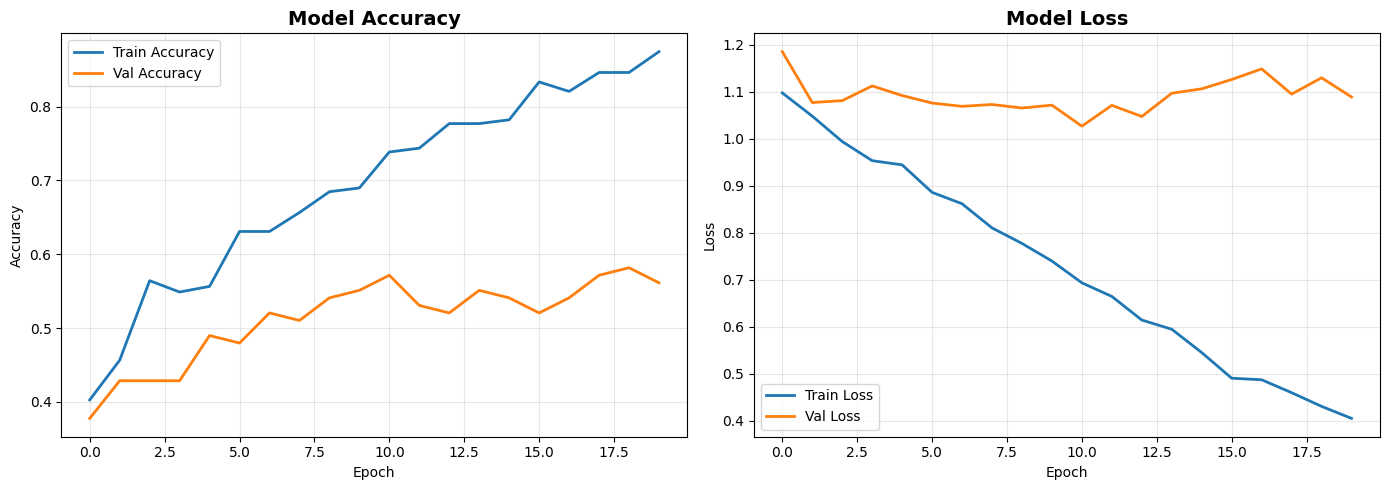


 Training Analysis:
  • Gap between training and validation curves indicates overfitting.
  • Train accuracy (~0.87) significantly higher than validation accuracy (~0.56).
  • A more complex sequence model (e.g., LSTM/attention) or stronger regularization might help.


In [21]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Training Analysis:")
print("  • Gap between training and validation curves indicates overfitting.")
print("  • Train accuracy (~0.87) significantly higher than validation accuracy (~0.56).")
print("  • A more complex sequence model (e.g., LSTM/attention) or stronger regularization might help.")

## 12. Prediction Function

Create a helper function to predict the class of a new audio file. This matches the `pipeline()` function from the reference implementation.

In [20]:
def predict_audio_file(filename):
    """
    Predict the class of an audio file using the trained model.
    This function replicates the pipeline() function from the reference implementation.
    
    Args:
        filename: Path to audio file
    
    Returns:
        predicted_class: Predicted class name (bird, cat, or dog)
        confidence: Confidence score (probability)
        probabilities: Array of probabilities for all classes
    """
    # Load and preprocess audio
    sample_rate, wav_data = read_audio(filename)
    
    # Normalize waveform (already normalized by librosa, but ensure float32)
    waveform_normalized = wav_data.astype(np.float32)
    
    # Convert to Tensor
    waveform_tf = tf.convert_to_tensor(waveform_normalized, dtype=tf.float32)
    
    # Extract embeddings
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # Pad/truncate to fixed length
    frames = embeddings.shape[0]
    if frames >= MAX_FRAMES:
        embeddings_trimmed = embeddings[:MAX_FRAMES, :]
    else:
        padding_needed = MAX_FRAMES - frames
        embeddings_trimmed = tf.pad(embeddings, [[0, padding_needed], [0, 0]])
    
    # Reshape for model input: (1, 100, 1024)
    embeddings_batch = tf.reshape(embeddings_trimmed, (1, MAX_FRAMES, 1024))
    
    # Predict
    prob = model.predict(embeddings_batch, verbose=0)[0]
    max_index = np.argmax(prob)
    
    predicted_class = CLASS_NAMES[max_index]
    confidence = prob[max_index]
    
    return predicted_class, confidence, prob

# Test the prediction function
test_file = list((DATA_DIR / "cat").glob("*.wav"))[0] if (DATA_DIR / "cat").exists() else None
if test_file:
    pred_class, confidence, probs = predict_audio_file(str(test_file))
    print(f"Test file: {test_file.name}")
    print(f"Predicted class: {pred_class} (confidence: {confidence:.4f})")
    print(f"\nAll class probabilities:")
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"  {class_name}: {probs[i]:.4f}")

Test file: e3e49931_nohash_0.wav
Predicted class: cat (confidence: 0.7537)

All class probabilities:
  dog: 0.0875
  cat: 0.7537
  bird: 0.1588


## 13. Summary and Comparison

### Key Results

- **Test Accuracy**: ~66% (0.66)
- **Approach**: Full sequence of YAMNet embeddings (100 frames × 1024 dims) → flattened → Dense classifier

### Comparison with Other Approaches

| Model | Feature Type | Test Accuracy | Notes |
|-------|-------------:|--------------:|-------|
| **YAMNet Embeddings (Full Sequence)** | Embeddings (100×1024) | **~66%** | This notebook - preserves temporal info |
| YAMNet Embeddings (Averaged) | Embeddings (1024) | ~62% | Notebook 05 - averages over time |
| CNN + Dropout(0.3) | Mel-spectrogram | ~88% | Notebook 04 - best CNN model |
| Baseline 2D CNN | Mel-spectrogram | ~84% | Notebook 04 |

### Key Findings

1. **Preserving temporal information** in YAMNet embeddings (full sequence) improves performance compared to averaging (~66% vs ~62%).

2. However, **training from scratch on Mel-spectrograms still outperforms** transfer learning approaches (~88% vs ~66%).

3. The full embedding sequence approach captures more information than averaging, but the **task-specific CNN learns better representations** for this particular animal sound classification task.

4. Transfer learning can be useful when:
   - Limited training data
   - Need for quick prototyping
   - Domain is similar to pre-training data

5. For this dataset, **domain-specific features (Mel-spectrograms) + custom CNN** work best, suggesting that the animal sound classification task benefits from learning task-specific patterns rather than generic audio event features.

### Why Transfer Learning Underperformed

- **Domain mismatch**: YAMNet was trained on AudioSet (general audio events), not specifically on animal sounds
- **Small dataset**: With 610 samples, we can train a task-specific model effectively
- **Feature mismatch**: Mel-spectrograms may be more suitable for this task than YAMNet embeddings
- **Architecture**: The simple Dense head may not be optimal for the embedding space

### Future Improvements

- Try more sophisticated architectures on top of embeddings (e.g., LSTM, attention mechanisms)
- Fine-tune YAMNet layers instead of freezing them
- Experiment with different embedding aggregation strategies (max pooling, attention pooling)
- Combine YAMNet embeddings with Mel-spectrogram features